Assignment 2 - Big Data with H2O

**Multiclass Classification** 

In [1]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import matplotlib.pyplot as plt

Set up some parameters for the analysis.  

In [2]:
data_path=None
all_variables=None
test_path=None
target=None
nthreads=1 
min_mem_size=6 
run_time=333
classification=False
scale=False
max_models=9    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0 

The next sections contains helper functions for automating analysis.             

In [3]:
# Functions

def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str
  
  
def set_meta_data(run_id,analysis,target,run_time,classification,scale,model,balance,balance_threshold,name,nthreads,min_mem_size):
  m_data={}
  m_data['run_id'] =run_id
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
  return m_data


def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
  
  
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm

def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    
def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d
    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:
      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d
    
def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


def get_independent_variables(df, targ):
    C = [name for name in df.columns if name != targ]
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in C:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    x=ints+enums+reals
    return x
    
def get_all_variables_csv(i):
    ivd={}
    try:
      iv = pd.read_csv(i,header=None)
    except:
      sys.exit(1)    
    col=iv.values.tolist()[0]
    dt=iv.values.tolist()[1]
    i=0
    for c in col:
      ivd[c.strip()]=dt[i].strip()
      i+=1        
    return ivd
    
    

def check_all_variables(df,dct,y=None):     
    targ=list(dct.keys())     
    for key, val in df.types.items():
        if key in targ:
          if dct[key] not in ['real','int','enum']:                      
            targ.remove(key)  
    for key, val in df.types.items():
        if key in targ:            
          if dct[key] != val:
            print('convert ',key,' ',dct[key],' ',val)
            if dct[key]=='enum':
                try:
                  df[key] = df[key].asfactor() 
                except:
                  targ.remove(key)                 
            if dct[key]=='int': 
                try:                
                  df[key] = df[key].asnumeric() 
                except:
                  targ.remove(key)                  
            if dct[key]=='real':
                try:                
                  df[key] = df[key].asnumeric()  
                except:
                  targ.remove(key)                  
    if y is None:
      y=df.columns[-1] 
    if y in targ:
      targ.remove(y)
    else:
      y=targ.pop()            
    return targ    
    
def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return

def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    
    
#  End Functions

In [4]:
data_path='C:/Fall 2018 semester/Big Data Systems Intelligence and Analytics/kicks_multi.csv'

In [5]:
data_path = os.path.join(os.path.abspath(os.curdir),data_path)

In [6]:
all_variables=None

In [7]:
run_id=alphabet(9)
# run_id to std out
print (run_id) 

R97iMyBYd


In [8]:
server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir) 

In [9]:
# 65535 Highest port no
port_no=random.randint(5555,55555)
h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no)

Checking whether there is an H2O instance running at http://localhost:46244..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.181-b13, mixed mode)
  Starting server from C:\Users\Leo\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Leo\AppData\Local\Temp\tmpobxl3zk6
  JVM stdout: C:\Users\Leo\AppData\Local\Temp\tmpobxl3zk6\h2o_Leo_started_from_python.out
  JVM stderr: C:\Users\Leo\AppData\Local\Temp\tmpobxl3zk6\h2o_Leo_started_from_python.err
  Server is running at http://127.0.0.1:46244
Connecting to H2O server at http://127.0.0.1:46244... successful.


H2O cluster uptime:,12 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 9 days
H2O cluster name:,H2O_from_python_Leo_dy0p69
H2O cluster total nodes:,1
H2O cluster free memory:,5.750 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [10]:
# meta data
meta_data = set_meta_data(run_id,analysis,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,nthreads,min_mem_size)
print(meta_data)  

{'run_id': 'R97iMyBYd', 'start_time': 1540965849.587282, 'target': None, 'max_models': 9, 'run_time': 333, 'scale': False, 'classification': False, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1540965849.587282, 'execution_time': 0.0, 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [11]:
print(data_path)

C:/Fall 2018 semester/Big Data Systems Intelligence and Analytics/kicks_multi.csv


In [12]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [13]:
df.head()

C1,goal,state,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category
2842,8.51739,3,0,1,5,10,500,1
267,9.21044,1,65,1,10,20,1000,4
4803,8.69968,1,10,1,6,12,600,1
4224,8.1608,1,104,1,3,7,350,4
357,7.6014,0,4,1,2,4,200,4
7776,6.21661,1,8,1,0,1,50,1
4182,7.75191,1,58,1,2,4,232,4
6094,8.51739,0,37,1,5,10,500,4
2763,7.03527,1,31,1,1,2,113,2
7124,8.51739,0,6,1,5,10,500,1


In [14]:
df.describe()

Rows:4847
Cols:9




,C1,goal,state,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category
type,int,real,int,int,int,int,int,int,int
mins,0.0,0.6471032420585384,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,5012.6201774293395,8.643194705725616,0.7169383123581599,95.96265731380235,0.811429750361048,28.674025170208377,57.64699814318135,2890.4759645141316,2.2450809464508095
maxs,9998.0,16.118095750958314,5.0,36863.0,1.0,10000.0,20000.0,1000000.0,4.0
sigma,2876.166826033127,1.6166638291551194,0.9736138505350319,786.1895789915652,0.3912072154194023,219.79654934403067,439.5739967282338,21978.76920221964,1.29665934157925
zeros,1,0,2478,642,914,542,220,12,0
missing,0,0,0,0,0,0,0,0,832
0,2842.0,8.517393171418904,3.0,0.0,1.0,5.0,10.0,500.0,1.0
1,267.0,9.210440366976515,1.0,65.0,1.0,10.0,20.0,1000.0,4.0
2,4803.0,8.699681400989514,1.0,10.0,1.0,6.0,12.0,600.0,1.0


describe()[source]
Generate an in-depth description of this H2OFrame.

The description is a tabular print of the type, min, max, sigma, number of zeros, and number of missing elements for each H2OVec in this H2OFrame.

Returns:	None (print to stdout) 

In [15]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
  target=df.columns[-1]   
y = target

In [16]:
print(y)

main_category


In [17]:
print(all_variables)

None


In [18]:
if all_variables is not None:
  ivd=get_all_variables_csv(all_variables)
  print(ivd)    
  X=check_all_variables(df,ivd,y)
  print(X)

In [19]:
df.describe()

Rows:4847
Cols:9




,C1,goal,state,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category
type,int,real,int,int,int,int,int,int,int
mins,0.0,0.6471032420585384,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,5012.6201774293395,8.643194705725616,0.7169383123581599,95.96265731380235,0.811429750361048,28.674025170208377,57.64699814318135,2890.4759645141316,2.2450809464508095
maxs,9998.0,16.118095750958314,5.0,36863.0,1.0,10000.0,20000.0,1000000.0,4.0
sigma,2876.166826033127,1.6166638291551194,0.9736138505350319,786.1895789915652,0.3912072154194023,219.79654934403067,439.5739967282338,21978.76920221964,1.29665934157925
zeros,1,0,2478,642,914,542,220,12,0
missing,0,0,0,0,0,0,0,0,832
0,2842.0,8.517393171418904,3.0,0.0,1.0,5.0,10.0,500.0,1.0
1,267.0,9.210440366976515,1.0,65.0,1.0,10.0,20.0,1000.0,4.0
2,4803.0,8.699681400989514,1.0,10.0,1.0,6.0,12.0,600.0,1.0


In [20]:
# independent variables

X = []  
if all_variables is None:
  X=get_independent_variables(df, target)  
else: 
  ivd=get_all_variables_csv(all_variables)    
  X=check_all_variables(df, ivd)


X=check_X(X,df)


# Add independent variables

meta_data['X']=X  


# impute missing values

_=impute_missing_values(df,X, scale)

In [21]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [22]:
print(classification)

False


In [23]:
# Force target to be factors
# Only 'int' or 'string' are allowed for asfactor(), got Target (Total orders):real 

if classification:
    df[y] = df[y].asfactor()

In [24]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok, val   

In [25]:
ok,val=check_y(y,df)

In [26]:
print(val)

int


In [27]:
print(ok)

True


In [28]:
if val=='enum':
    print(df[y].levels())

In [29]:
df.describe()

Rows:4847
Cols:9




,C1,goal,state,backers,country_is_us,Goal_1000,Goal_500,Goal_10,main_category
type,int,real,int,int,int,int,int,int,int
mins,0.0,0.6471032420585384,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,5012.6201774293395,8.643194705725616,0.7169383123581599,95.96265731380235,0.811429750361048,28.674025170208377,57.64699814318135,2890.4759645141316,2.2450809464508095
maxs,9998.0,16.118095750958314,5.0,36863.0,1.0,10000.0,20000.0,1000000.0,4.0
sigma,2876.166826033127,1.6166638291551194,0.9736138505350319,786.1895789915652,0.3912072154194023,219.79654934403067,439.5739967282338,21978.76920221964,1.29665934157925
zeros,1,0,2478,642,914,542,220,12,0
missing,0,0,0,0,0,0,0,0,832
0,2842.0,8.517393171418904,3.0,0.0,1.0,5.0,10.0,500.0,1.0
1,267.0,9.210440366976515,1.0,65.0,1.0,10.0,20.0,1000.0,4.0
2,4803.0,8.699681400989514,1.0,10.0,1.0,6.0,12.0,600.0,1.0


In [30]:
allV=get_variables_types(df)
allV

{'C1': 'int',
 'Goal_10': 'int',
 'Goal_1000': 'int',
 'Goal_500': 'int',
 'backers': 'int',
 'country_is_us': 'int',
 'goal': 'real',
 'main_category': 'int',
 'state': 'int'}

In [31]:
meta_data['variables']=allV

In [32]:
# split into training and test for showing how to predict
train, test = df.split_frame([0.9])

In [33]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [34]:
model_start_time = time.time()

In [35]:
aml.train(x=X,y=y,training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [74]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [75]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [76]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417,1.581358,1.257520,1.581358,1.118499,0.388043
1,GBM_grid_0_AutoML_20181031_020417_model_17,1.583663,1.258437,1.583663,1.124253,0.388676
2,GBM_grid_0_AutoML_20181031_020417_model_16,1.584871,1.258917,1.584871,1.116991,0.388398
3,GBM_grid_0_AutoML_20181031_020417_model_4,1.585802,1.259286,1.585802,1.115401,0.388457
4,StackedEnsemble_AllModels_0_AutoML_20181031_020417,1.588741,1.260453,1.588741,1.123354,0.388958
5,GBM_grid_0_AutoML_20181031_020417_model_31,1.590106,1.260994,1.590106,1.126381,0.389260
6,GBM_grid_0_AutoML_20181031_020417_model_20,1.595450,1.263111,1.595450,1.122631,0.390178
7,GLM_grid_0_AutoML_20181031_020417_model_0,1.624539,1.274574,1.624539,1.137238,0.393186
8,DeepLearning_0_AutoML_20181031_020417,1.625561,1.274975,1.625561,1.111266,NaN
9,GBM_grid_0_AutoML_20181031_020417_model_1,1.625830,1.275080,1.625830,1.119050,0.392730


In [77]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [78]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417'

In [79]:
# Get stacked ensemble  
se=get_stacked_ensemble(model_set)

In [80]:
print(se)

StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417


In [81]:
if se is not None:
  mod_best=h2o.get_model(se)

In [82]:
mod_best._id

'StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417'

In [83]:
mod_best._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics>

In [84]:
type(mod_best)

h2o.estimators.stackedensemble.H2OStackedEnsembleEstimator

In [85]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417
No model summary for this model


ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 1.517209981904263
RMSE: 1.2317507791368605
MAE: 1.0916770448006423
RMSLE: 0.37948950579139884
R^2: 0.10189423659378538
Mean Residual Deviance: 1.517209981904263
Null degrees of freedom: 2904
Residual degrees of freedom: 2901
Null deviance: 4907.545611015491
Residual deviance: 4407.494997431884
AIC: 9465.04926238999

ModelMetricsRegressionGLM: stackedensemble
** Reported on validation data. **

MSE: 1.5503515598015798
RMSE: 1.2451311416078146
MAE: 1.1003685768719615
RMSLE: 0.38642859747463054
R^2: 0.06660656392155828
Mean Residual Deviance: 1.5503515598015798
Null degrees of freedom: 679
Residual degrees of freedom: 676
Null deviance: 1130.6278776280433
Residual deviance: 1054.2390606650742
AIC: 2237.923973390358

ModelMetricsRegressionGLM: stackeden

In [86]:
bm=stackedensemble_df(aml_leaderboard_df)

In [87]:
bm

['GBM_grid_0_AutoML_20181031_020417_model_17',
 'GLM_grid_0_AutoML_20181031_020417_model_0',
 'DRF_0_AutoML_20181031_020417',
 'XRT_0_AutoML_20181031_020417',
 'DeepLearning_0_AutoML_20181031_020417']

In [88]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417,1.581358,1.257520,1.581358,1.118499,0.388043
1,GBM_grid_0_AutoML_20181031_020417_model_17,1.583663,1.258437,1.583663,1.124253,0.388676
2,GBM_grid_0_AutoML_20181031_020417_model_16,1.584871,1.258917,1.584871,1.116991,0.388398
3,GBM_grid_0_AutoML_20181031_020417_model_4,1.585802,1.259286,1.585802,1.115401,0.388457
4,StackedEnsemble_AllModels_0_AutoML_20181031_020417,1.588741,1.260453,1.588741,1.123354,0.388958
5,GBM_grid_0_AutoML_20181031_020417_model_31,1.590106,1.260994,1.590106,1.126381,0.389260
6,GBM_grid_0_AutoML_20181031_020417_model_20,1.595450,1.263111,1.595450,1.122631,0.390178
7,GLM_grid_0_AutoML_20181031_020417_model_0,1.624539,1.274574,1.624539,1.137238,0.393186
8,DeepLearning_0_AutoML_20181031_020417,1.625561,1.274975,1.625561,1.111266,NaN
9,GBM_grid_0_AutoML_20181031_020417_model_1,1.625830,1.275080,1.625830,1.119050,0.392730


In [89]:
#  Get best_models and coef_norm()
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [90]:
bm

['GBM_grid_0_AutoML_20181031_020417_model_17',
 'GLM_grid_0_AutoML_20181031_020417_model_0',
 'DeepLearning_0_AutoML_20181031_020417',
 'XRT_0_AutoML_20181031_020417',
 'DRF_0_AutoML_20181031_020417',
 'StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417']

In [91]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]


In [92]:
aml_leaderboard_df

,model_id,mean_residual_deviance,rmse,mse,mae,rmsle
0,StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417,1.581358,1.257520,1.581358,1.118499,0.388043
1,GBM_grid_0_AutoML_20181031_020417_model_17,1.583663,1.258437,1.583663,1.124253,0.388676
7,GLM_grid_0_AutoML_20181031_020417_model_0,1.624539,1.274574,1.624539,1.137238,0.393186
8,DeepLearning_0_AutoML_20181031_020417,1.625561,1.274975,1.625561,1.111266,NaN
31,XRT_0_AutoML_20181031_020417,1.781633,1.334778,1.781633,1.156203,0.410419
33,DRF_0_AutoML_20181031_020417,1.809034,1.345003,1.809034,1.157787,0.412910


In [93]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [94]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417


In [95]:
mod_best=h2o.get_model(top)
print(mod_best._id)
print(mod_best.algo)

StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417
stackedensemble


In [96]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo

In [97]:
meta_data['models']=bm

In [98]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass    

In [99]:
print(models_path)

C:\Users\Leo\Desktop\CSYE_7245-master\BDIA Assignemnt 2\R97iMyBYd\models


In [100]:
# GBM
 
mod,mod_id=get_model_by_algo("GBM",best_models)
if mod is not None:
    try:     
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
    except:
        pass   
    try:     
        stats_gbm={}
        stats_gbm=gbm_stats(mod)
        n=run_id+'_gbm_stats.json'
        dict_to_json(stats_gbm,n)
        print(stats_gbm)
    except:
        pass        

{'algo': 'gbm', 'model_id': 'GBM_grid_0_AutoML_20181031_020417_model_17', 'varimp': [('goal', 1148.742431640625, 1.0, 0.26449372910579816), ('backers', 760.2366943359375, 0.6617990886348416, 0.1750417088718479), ('C1', 753.1458740234375, 0.655626407869169, 0.17340907351755552), ('Goal_10', 575.1328735351562, 0.5006630361113726, 0.13242223344652782), ('Goal_500', 467.9831237792969, 0.40738734018114664, 0.10775139679500383), ('Goal_1000', 318.68426513671875, 0.27742012165562335, 0.07337588250568), ('country_is_us', 200.57115173339844, 0.174600629530977, 0.04618077160886805), ('state', 118.67813110351562, 0.10331134972878163, 0.027325204148718737)]}


In [101]:
# DeepLearning

mod,mod_id=get_model_by_algo("Dee",best_models)


In [102]:
if mod is not None:
    try:    
        sh_df=mod.scoring_history()
        sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
    except:
        pass 
    try:
        stats_dl={}
        stats_dl=dl_stats(mod)
        n=run_id+'_dl_stats.json'
        dict_to_json(stats_dl,n)
        print(stats_dl)
    except:
        pass    
    try:
        cf=mod.confusion_matrix()    
        cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
    except:
        pass       

{'algo': 'deeplearning', 'model_id': 'DeepLearning_0_AutoML_20181031_020417', 'varimp': [('Goal_1000', 1.0, 1.0, 0.15710453578937023), ('backers', 0.9833250045776367, 0.9833250045776367, 0.15448481837424996), ('Goal_500', 0.8081945180892944, 0.8081945180892944, 0.12697102459193238), ('goal', 0.8053200840950012, 0.8053200840950012, 0.12651943797360177), ('C1', 0.7463532090187073, 0.7463532090187073, 0.11725547443779082), ('Goal_10', 0.7434607744216919, 0.7434607744216919, 0.1168010598431256), ('country_is_us', 0.671288788318634, 0.671288788318634, 0.10546251346940781), ('state', 0.6072462201118469, 0.6072462201118469, 0.09540113552052144)]}


In [103]:
# DRF

mod,mod_id=get_model_by_algo("DRF",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
    except:
         pass  
    try: 
         stats_drf={}
         stats_drf=drf_stats(mod)
         n=run_id+'_drf_stats.json'
         dict_to_json(stats_drf,n)
         print(stats_drf)
    except:
         pass     

In [104]:
# XRT

mod,mod_id=get_model_by_algo("XRT",best_models)
if mod is not None:
    try:     
         sh_df=mod.scoring_history()
         sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
    except:
         pass     
    try:        
         stats_xrt={}
         stats_xrt=xrt_stats(mod)
         n=run_id+'_xrt_stats.json'
         dict_to_json(stats_xrt,n)
         print(stats_xrt)
    except:
         pass     

In [105]:
# GLM

mod,mod_id=get_model_by_algo("GLM",best_models)
if mod is not None:
    try:     
         stats_glm={}
         stats_glm=glm_stats(mod)
         n=run_id+'_glm_stats.json'
         dict_to_json(stats_glm,n)
         print(stats_glm)
    except:
         pass     

{'algo': 'glm', 'model_id': 'GLM_grid_0_AutoML_20181031_020417_model_0', 'coef': {'Intercept': 3.450672670435565, 'C1': -5.1542659112169265e-06, 'goal': -0.16585897416270884, 'state': -0.00206490689072177, 'backers': 0.0003819864542251945, 'country_is_us': 0.2715508233641955, 'Goal_1000': 5.065464231748706e-05, 'Goal_500': 1.499573978090446e-05, 'Goal_10': 2.186447973077968e-07}, 'coef_norm': {'Intercept': 2.2552446421915717, 'C1': -0.014822550495196016, 'goal': -0.27020349619877, 'state': -0.0020277328187647756, 'backers': 0.34757562832077915, 'country_is_us': 0.10562355770851699, 'Goal_1000': 0.012036736735929834, 'Goal_500': 0.00712641144038517, 'Goal_10': 0.0051953347295478885}}


In [106]:
predictions_df=predictions_test(mod_best,test,run_id)

stackedensemble prediction progress: |████████████████████████████████████| 100%


In [107]:
predictions_df.head()

predict
2.76483
2.0842
2.25049
2.43445
2.21192
2.7972
2.15248
2.60795
2.85335
2.71767


In [108]:
predictions_df.describe()

Rows:508
Cols:1




,predict
type,real
mins,1.435953844684749
mean,2.214707763653812
maxs,2.9340571159825646
sigma,0.3673406307727966
zeros,0
missing,0
0,2.7648286846723007
1,2.08419976619466
2,2.250494807637183


In [117]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)    


In [118]:
meta_data

{'X': ['C1',
  'state',
  'backers',
  'country_is_us',
  'Goal_1000',
  'Goal_500',
  'Goal_10',
  'goal'],
 'analysis': 0,
 'balance': False,
 'balance_threshold': 0.2,
 'classification': False,
 'end_time': 1540966367.940429,
 'execution_time': 518.3531470298767,
 'max_models': 9,
 'min_mem_size': 6,
 'mod_best': 'StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417',
 'mod_best_algo': 'stackedensemble',
 'model_execution_time': 374.23037004470825,
 'models': ['GBM_grid_0_AutoML_20181031_020417_model_17',
  'GLM_grid_0_AutoML_20181031_020417_model_0',
  'DeepLearning_0_AutoML_20181031_020417',
  'XRT_0_AutoML_20181031_020417',
  'DRF_0_AutoML_20181031_020417',
  'StackedEnsemble_BestOfFamily_0_AutoML_20181031_020417'],
 'nthreads': 1,
 'project': None,
 'run_id': 'R97iMyBYd',
 'run_time': 333,
 'scale': False,
 'start_time': 1540965849.587282,
 'target': None,
 'variables': {'C1': 'int',
  'Goal_10': 'int',
  'Goal_1000': 'int',
  'Goal_500': 'int',
  'backers': 'int',
  'country_i

In [119]:
mod_best.varimp_plot()

TypeError: 'NoneType' object is not iterable

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


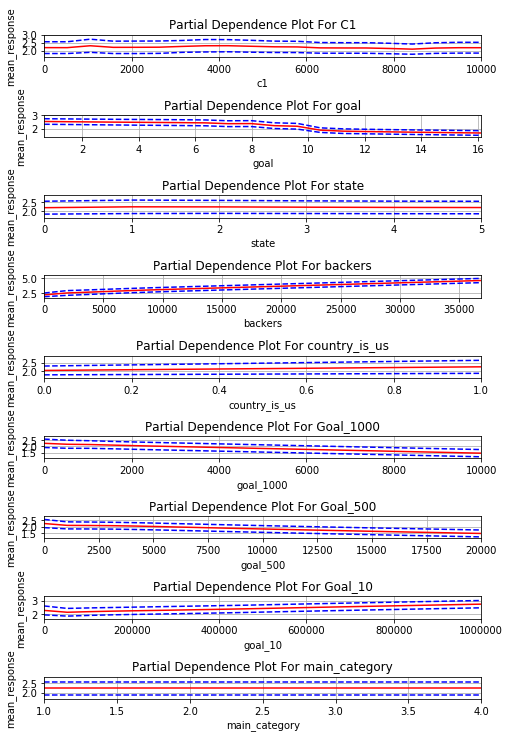

In [112]:
aml.leader.partial_plot(data=df, cols=df.columns)
plt.show()

In [ ]:
# Clean up
os.chdir(server_path)

In [ ]:
h2o.cluster().shutdown()